In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def seasonal_factors_mul(s, d, slen, cols): #slen = sum of factors
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen])

    s /= np.mean(s[:slen]) #scale all season factors

    return s


In [12]:
def triple_smooth_mul(d, slen = 12, extra_periods = 1, alpha = 0.4, beta = 0.4, phi = 0.9, gamma = 0.3):

    cols = len(d) #historical period length
    d = np.append(d, [np.nan]* extra_periods) #append np.nan inot the demand array for future periods

    # components initialization

    f,a,b,s = np.full((4,cols+extra_periods), np.nan)
    s = seasonal_factors_mul(s,d,slen,cols)

    #level and trend initialization
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0]

    #create the forecast for the first season
    for t in range(1,slen):
        f[t] = (a[t-1] + phi*b[t-1]) * s[t]
        a[t] = alpha*d[t]/s[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

    #create all the t+1 forecast
    for t in range (slen,cols):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = alpha*d[t]/s[t-slen] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*d[t]/a[t] + (1-gamma)*s[t-slen]

    #forecast for all extra periods
    for t in range(cols, cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1]) * s[t-slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Season':s, 'Error':d-f})
    return df


In [13]:
def kpi(df):
    #average demand
    dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
    #absolute bias
    bias_abs = df['Error'].mean()
    #relative bias
    bias_rel = bias_abs / dem_ave
    #print results 
    print('Bias: {:0.2f}, {:.2%}'.format(bias_abs, bias_rel))

    #calculate MAPE
    MAPE = (df['Error'].abs() / df['Demand']).mean()
    #print results
    print('MAPE: {:0.2%}'.format(MAPE))

    #calculate absoltue and scaled MAE
    MAE_abs = df['Error'].abs().mean()
    MAE_rel = MAE_abs / dem_ave
    #print results
    print('MAE: {:0.2f}, {:0.2%}'.format(MAE_abs,MAE_rel))

    #calculate absolute and scaled RSME
    RMSE_abs = np.sqrt((df['Error']**2).mean())
    RMSE_rel =  RMSE_abs / dem_ave
    #print results
    print('RMSE: {:0.2f}, {:0.2%}'.format(RMSE_abs,RMSE_rel))

In [14]:
d = [14,10,6,2,18,8,4,1,16,9,5,3,18,11,4,2,17,9,5,1]
df = triple_smooth_mul(d, slen=12, extra_periods = 4, alpha = 0.3, beta = 0.2, phi=0.9, gamma=0.2)
df

,Demand,Forecast,Level,Trend,Season,Error
0,14.0,NaN,7.145833,0.631944,1.959184,NaN
1,10.0,9.918750,7.733542,0.572542,1.285714,0.081250
2,6.0,5.050304,8.714180,0.608358,0.612245,0.949696
3,2.0,2.268172,8.933192,0.481820,0.244898,-0.268172
4,18.0,20.071778,9.076781,0.375628,2.142857,-2.071778
5,8.0,9.799125,8.896275,0.234351,1.040816,-1.799125
6,4.0,5.018248,8.552811,0.100040,0.551020,-1.018248
7,1.0,1.058308,8.499993,0.061465,0.122449,-0.058308
8,16.0,16.761427,8.438718,0.032000,1.959184,-0.761427
9,9.0,9.331551,8.377263,0.010749,1.102041,-0.331551


In [15]:
kpi(df)

Bias: -0.19, -2.39%
MAPE: 9.30%
MAE: 0.64, 8.12%
RMSE: 0.92, 11.74%


<AxesSubplot:title={'center':'Triple Smoothing'}>

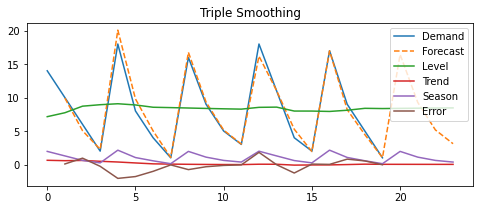

In [17]:
df[['Demand','Forecast','Level','Trend','Season','Error']].plot(figsize = (8,3), title = 'Triple Smoothing', style = ['-','--'])